In [111]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [112]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [113]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [114]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [115]:
# reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect = True)

In [116]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [117]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [118]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [119]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """  
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [120]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for dates of interest - August 1 to August 7 for previous year in the data set
start_date = '2017-08-01'
end_date = '2017-08-07'

temps = [t for t in calc_temps(start_date, end_date)[0]]
temps

[72.0, 79.25, 83.0]

<ErrorbarContainer object of 3 artists>

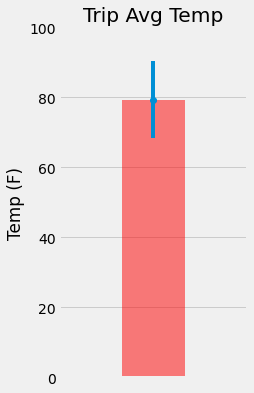

In [121]:
# Plot the results from your previous query as a bar chart.
fig, ax = plt.subplots(figsize=(3,6))
plt.bar(1, temps[1], color='r', width = 0.2, alpha=0.5, align="center")
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xlim(0.7,1.3)
plt.ylim(0,100)
ax.axes.xaxis.set_visible(False)
ax.errorbar(1, temps[1], temps[2] - temps[0], fmt="o")

### Daily Rainfall Average

In [122]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def calc_rain(start_date, end_date):
    sel = [Measurement.date, func.sum(Measurement.prcp),
           Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
    
    return session.query(*sel).\
            filter(Station.station == Measurement.station).\
            filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
            group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()

In [123]:
calc_rain(start_date, end_date)

[('2017-08-01',
  0.36,
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('2017-08-01',
  0.22,
  'USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('2017-08-04',
  0.06,
  'USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('2017-08-01',
  0.04,
  'USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('2017-08-01',
  0.0,
  'USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5)]

In [124]:
# Calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
def daily_normals(date):
    """Daily Normals.  
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    """
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()[0]

In [125]:
# Calculate the daily normals for your trip

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start_date, end_date, 7)
print(trip_dates)

# Strip off the year and save a list of strings in the format %m-%d
query_dates = trip_dates.strftime('%m-%d')  
print(f"After format: {query_dates}")

# Use the `daily_normals` function to calculate the normals for each date string
# and append the results to a list called `normals`.
normals = [daily_normals(date) for date in query_dates]
normals

DatetimeIndex(['2017-08-01', '2017-08-02', '2017-08-03', '2017-08-04',
               '2017-08-05', '2017-08-06', '2017-08-07'],
              dtype='datetime64[ns]', freq=None)
After format: Index(['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07'], dtype='object')


[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [126]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['MIN', 'AVG', 'MAX'])
df["Date"] = trip_dates
df.set_index('Date', inplace=True)
df.head(20)

,MIN,AVG,MAX
Date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


Text(0, 0.5, 'Temp (F)')

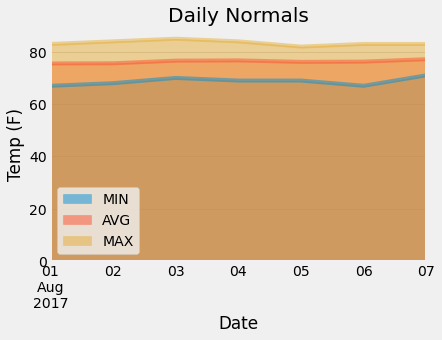

In [127]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked = False)
plt.title("Daily Normals")
plt.ylabel("Temp (F)")

## Close Session

In [128]:
session.close()